In [2]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.dagcircuit import DAGCircuit
from qiskit.converters import circuit_to_dag
from qiskit.visualization import dag_drawer
from network_utils_hybrid import *

import numpy as np
import matplotlib.pyplot as plt
import random

Initialize netowrk topology

In [3]:
Nrep = 100
num_gates_list = np.arange(10,41,10)
num_ToR = 10
n = 6 # must be even, starts from 4

specs = {
    "num_sw_ports": n,
    "num_ToR" : num_ToR,
    "qs_per_node" : 4,
    "bandwidth" : 2,
    "num_bsm_ir" : 2,
    "num_bsm_tel" : 2,
    "num_pd" : 1, # inactive
    "num_laser" : 1, # inactive
    "num_bs" : 1, # inactive
    "num_es" : 1 # inactive
}

G, vertex_list = clos_hybrid(specs)
edge_switches, node_list, node_qubit_list =  vertex_list
qubit_nx_to_qiskit = {qubit: idx for idx, qubit in enumerate(node_qubit_list)}


Generate a random circuit

In [75]:
num_nodes = len(node_list)
num_qubits = len(node_qubit_list)
qubit_list = range(num_qubits//num_nodes)

num_gates = 100
connections = []
for i in range(num_nodes):
    for j in range(i+1,num_nodes):
        if np.random.rand() > 0.5:
            connections.append((node_list[i],node_list[j]))
        else:
            connections.append((node_list[j],node_list[i]))

gate_seq_nodes = random.choices(connections, k=num_gates)
# print(gate_seq_nodes)
gate_seq_input = []
for n1, n2 in gate_seq_nodes:
    gate_seq_input.append((f"{n1},{random.sample(qubit_list,1)[0]}",f"{n2},{random.sample(qubit_list,1)[0]}"))

print(gate_seq_input)

[('22,2', '58,3'), ('42,0', '104,0'), ('20,0', '65,3'), ('49,1', '33,1'), ('74,1', '96,1'), ('103,1', '91,3'), ('86,2', '107,3'), ('64,2', '44,1'), ('68,0', '104,0'), ('58,3', '76,2'), ('37,2', '43,2'), ('76,2', '87,3'), ('81,3', '41,1'), ('105,3', '106,3'), ('65,1', '67,2'), ('78,1', '46,0'), ('75,0', '66,0'), ('50,1', '26,2'), ('91,3', '60,0'), ('35,1', '84,1'), ('62,1', '67,1'), ('28,1', '47,1'), ('102,2', '104,2'), ('75,1', '100,0'), ('50,0', '64,3'), ('48,2', '44,0'), ('103,3', '91,3'), ('66,2', '84,2'), ('50,0', '38,2'), ('67,0', '31,3'), ('56,2', '51,3'), ('56,0', '39,2'), ('78,2', '48,2'), ('39,2', '102,3'), ('84,2', '47,2'), ('91,3', '92,3'), ('47,2', '64,3'), ('77,2', '47,1'), ('59,2', '62,3'), ('54,3', '38,1'), ('83,0', '40,3'), ('62,0', '103,0'), ('96,3', '92,2'), ('46,3', '27,1'), ('66,3', '71,0'), ('77,2', '37,3'), ('75,0', '100,1'), ('19,2', '45,1'), ('34,0', '22,3'), ('70,3', '59,2'), ('76,1', '48,3'), ('60,2', '36,2'), ('93,1', '62,2'), ('53,1', '103,0'), ('56,0', '47,

# Transpiler based on DAG

In [91]:
qiskit_q_list = QuantumRegister(num_qubits, "q")
circ = QuantumCircuit(qiskit_q_list)

for g in gate_seq_input:
    circ.cx(qubit_nx_to_qiskit[g[0]], qubit_nx_to_qiskit[g[1]])
# print(circ)

dag = circuit_to_dag(circ)
dag_qubit_map = {bit: index for index, bit in enumerate(dag.qubits)}

edge_switches, node_list, node_qubit_list = vertex_list
num_nodes = len(node_list)
num_edge = len(edge_switches)
switch_seq = []

counter = 0 
while len(dag.gate_nodes())>0:

    indep_gate_seq = []
    dag_node_seq = []
    for node in dag.front_layer():
        if node.op.num_qubits< 2:
            dag.remove_op_node(node)
        if node.op.num_qubits>= 2:
            # gate_set.append((dag_qubit_map[node.qargs[0]],dag_qubit_map[node.qargs[1]]))
            indep_gate_seq.append((node_qubit_list[dag_qubit_map[node.qargs[0]]],node_qubit_list[dag_qubit_map[node.qargs[1]]]))
            dag_node_seq.append(node)
            # dag.remove_op_node(node)

    # if counter >7:
    #     # dag_drawer(dag)
    #     print(indep_gate_seq)
    # counter += 1


    num_ir_swap = 0
    num_tel_swap = 0
    G_ins =  G.copy()
    inds_keep = []
    ####
    # g_exec = [] ###
    # random.shuffle(indep_gate_seq)
    indep_gate_seq = sorted(indep_gate_seq, key=lambda x: random.random())

    for i_g, g in enumerate(indep_gate_seq):
        # for link in range(gate_mul_seq_iter[g]):
        n0 = g[0]
        n1 = g[1]
        if nx.has_path(G_ins,n0,n1):
            paths = nx.all_shortest_paths(G_ins, n0, n1, weight=None)
            # path_found = False
            for shortestpath in paths:
                tel_ir = "ir"
                if len(shortestpath)> 5 :
                    tel_ir = "tel"

                sp = []
                b = []
                for i in range(0,len(shortestpath)-1):
                    sp.append((shortestpath[i],shortestpath[i+1]))
                    if 1 < i < len(shortestpath)-2:
                        sw = shortestpath[i]
                        if G_ins.nodes[sw]["BSM_"+tel_ir] > 0:
                            b.append(sw)
                
                if len(b)>=1:
                    sw_bsm = random.sample(b,1)[0]
                    G_ins.nodes[sw_bsm]["BSM_"+tel_ir]-= 1
                    for u, v in sp:
                        if G_ins[u][v]['weight'] == 1:
                            G_ins.remove_edge(u, v)
                        else:
                            G_ins[u][v]['weight'] -= 1
                    if  tel_ir == "tel":
                        num_tel_swap += 1
                    else:
                        num_ir_swap += 1
                    
                    # path_found = True
                    dag.remove_op_node(dag_node_seq[i_g])
                    break

        #     if not path_found:
        #         break
        # else:
        #     break

    # switch_time.append([num_ir_swap, num_tel_swap])
    # gate_seq_iter = [gate_seq_iter[idx] for idx in inds_keep]

    switch_seq.append([num_ir_swap, num_tel_swap])

# print(switch_seq)
print("num seq:", len(gate_seq_input), ", num switch:", len(switch_seq), ",",switch_seq)

num seq: 100 , num switch: 7 , [[8, 12], [7, 12], [5, 12], [3, 12], [3, 12], [2, 7], [1, 4]]


# Original transpiler (baseline)

In [83]:
gate_seq_iter = gate_seq_input.copy()

Q = nx.Graph()
Q.add_nodes_from(node_qubit_list)

query_seq = []
query = []
gate_mul = {}
gate_mul_seq = []
while len(gate_seq_iter)>0:
    # print(gate_seq_iter)
    inds_keep = []
    not_block_gate = True
    for i_g, gate_nodes in enumerate(gate_seq_iter):
        if Q.degree[gate_nodes[0]] > 0 or Q.degree[gate_nodes[1]] > 0:
            # if gate_nodes in query and not_block_gate:
            #     gate_mul[gate_nodes] += 1
            #     # query.append(gate_nodes)
            # else:
            Q.add_edge(gate_nodes[0],gate_nodes[1])
            inds_keep.append(i_g)
            not_block_gate = False
        else:
            Q.add_edge(gate_nodes[0],gate_nodes[1])
            query.append(gate_nodes)
            gate_mul[gate_nodes] =  1
            not_block_gate = True

    query_seq.append(query)
    gate_mul_seq.append(gate_mul)
    query = []
    gate_mul = {}
    Q = nx.Graph()
    Q.add_nodes_from(node_qubit_list)
    gate_seq_iter = [gate_seq_iter[idx] for idx in inds_keep]

for i_q, gate_seq in enumerate(query_seq):

    gate_seq_iter = gate_seq[:]
    switch_time = []

    while len(gate_seq_iter)>0:
        # bsm_stat = np.ones(num_edge,dtype=np.int16)* num_bsm
        num_ir_swap = 0
        num_tel_swap = 0
        G_ins =  G.copy()

        # print(gate_seq_iter)
        inds_keep = []
        for i_g, g in enumerate(gate_seq_iter):
            n0 = g[0]
            n1 = g[1]
            if nx.has_path(G_ins,n0,n1):
                paths = nx.all_shortest_paths(G_ins, n0, n1, weight=None)
                path_found = False
                for shortestpath in paths:
                    tel_ir = "ir"
                    if len(shortestpath)> 5 :
                        tel_ir = "tel"

                    sp = []
                    b = []
                    for i in range(0,len(shortestpath)-1):
                        sp.append((shortestpath[i],shortestpath[i+1]))
                        if 1 < i < len(shortestpath)-2:
                            sw = shortestpath[i]
                            # print(sw)
                            if G_ins.nodes[sw]["BSM_"+tel_ir] > 0:
                                b.append(sw)
                    
                    if len(b)>=1:
                        sw_bsm = random.sample(b,1)[0]
                        G_ins.nodes[sw_bsm]["BSM_"+tel_ir]-= 1
                        for u, v in sp:
                            if G_ins[u][v]['weight'] == 1:
                                G_ins.remove_edge(u, v)
                            else:
                                G_ins[u][v]['weight'] -= 1
                        if  tel_ir == "tel":
                            num_tel_swap += 1
                        else:
                            num_ir_swap += 1
                        
                        path_found = True
                        break

                if not path_found:
                    inds_keep.append(i_g)
            else:
                inds_keep.append(i_g)

        switch_time.append([num_ir_swap, num_tel_swap])
        gate_seq_iter = [gate_seq_iter[idx] for idx in inds_keep]
    print("num seq:", len(gate_seq), ", num switch:", len(switch_time), ",",switch_time)


num seq: 55 , num switch: 4 , [[8, 12], [3, 12], [0, 12], [0, 8]]
num seq: 27 , num switch: 3 , [[2, 12], [0, 12], [0, 1]]
num seq: 12 , num switch: 1 , [[1, 11]]
num seq: 4 , num switch: 1 , [[1, 3]]
num seq: 2 , num switch: 1 , [[0, 2]]


# Basics
Stuff to learn basics of DAG, sanity checks, etc

In [9]:
qiskit_q_list = QuantumRegister(num_qubits, "q")
circ = QuantumCircuit(qiskit_q_list)

for g in gate_seq:
    circ.cx(qubit_nx_to_qiskit[g[0]], qubit_nx_to_qiskit[g[1]])
# print(circ)

dag = circuit_to_dag(circ)
dag_qubit_map = {bit: index for index, bit in enumerate(dag.qubits)}

# dag_drawer(dag)
qiskit_query_seq = []
while len(dag.gate_nodes())>0:
    gate_set = []
    for node in dag.front_layer():
        if node.op.num_qubits< 2:
            dag.remove_op_node(node)
        if node.op.num_qubits>= 2:
            gate_set.append([dag_qubit_map[node.qargs[0]],dag_qubit_map[node.qargs[1]]])
            # gate_set.append((node_qubit_list[dag_qubit_map[node.qargs[0]]],node_qubit_list[dag_qubit_map[node.qargs[1]]]))
            dag.remove_op_node(node)
    print((gate_set))
    qiskit_query_seq.append(gate_set)


[[11, 35], [3, 36], [10, 39], [61, 7], [69, 34], [18, 80], [88, 41], [91, 75], [83, 93], [43, 106], [121, 16], [126, 78], [130, 129], [86, 132], [137, 92], [138, 108], [143, 65], [146, 113], [149, 97], [150, 59], [123, 151], [153, 67], [158, 30], [13, 161], [23, 162], [159, 164], [55, 165], [42, 169], [21, 173], [156, 175], [133, 178], [179, 122], [33, 180], [184, 163], [186, 81], [136, 189], [191, 56], [194, 167], [148, 197], [208, 40], [29, 209], [31, 210], [213, 187], [220, 48], [222, 54], [128, 223], [109, 224], [226, 115], [232, 114], [94, 235], [237, 49], [142, 240], [241, 206], [242, 200], [134, 243], [111, 244], [245, 17], [253, 239], [267, 202], [255, 269]]
[[64, 75], [98, 34], [39, 100], [92, 102], [35, 105], [1, 121], [139, 11], [148, 37], [153, 60], [167, 172], [78, 185], [151, 194], [201, 49], [206, 63], [208, 31], [210, 202], [217, 7], [101, 220], [221, 213], [189, 232], [168, 245], [181, 253], [197, 254], [130, 263], [164, 266], [5, 267]]
[[16, 64], [37, 101], [121, 103]

In [10]:
gate_seq_iter = gate_seq.copy()

Q = nx.Graph()
Q.add_nodes_from(node_qubit_list)

query_seq = []
query = []
gate_mul = {}
gate_mul_seq = []
while len(gate_seq_iter)>0:
    # print(gate_seq_iter)
    inds_keep = []
    not_block_gate = True
    for i_g, gate_nodes in enumerate(gate_seq_iter):
        if Q.degree[gate_nodes[0]] > 0 or Q.degree[gate_nodes[1]] > 0:
            # if gate_nodes in query and not_block_gate:
            #     gate_mul[gate_nodes] += 1
            #     # query.append(gate_nodes)
            # else:
            Q.add_edge(gate_nodes[0],gate_nodes[1])
            inds_keep.append(i_g)
            not_block_gate = False
        else:
            Q.add_edge(gate_nodes[0],gate_nodes[1])
            query.append(gate_nodes)
            gate_mul[gate_nodes] =  1
            not_block_gate = True

    query_seq.append(query)
    gate_mul_seq.append(gate_mul)
    query = []
    gate_mul = {}
    Q = nx.Graph()
    Q.add_nodes_from(node_qubit_list)
    gate_seq_iter = [gate_seq_iter[idx] for idx in inds_keep]

# for query in query_seq:
for i_q, query in enumerate(query_seq):
    qiskit_query = []
    for gate in query:
        qiskit_query.append([qubit_nx_to_qiskit[gate[0]],qubit_nx_to_qiskit[gate[1]]])
    # print(sorted(qiskit_query))
    print(sorted(qiskit_query)==sorted(qiskit_query_seq[i_q]))
    # print(len(qiskit_query)==len(qiskit_query_seq[i_q]))
    
    # print(np.array_equal(np.array(qiskit_query), np.array(qiskit_query_seq[i_q]) ))

True
True
True
True
True


In [31]:
print(len(query_seq),len(qiskit_query_seq))

6 6


In [98]:
num_nodes = 8
node_list = range(num_nodes)
qubits_per_node = 4
qubit_list = range(qubits_per_node)
num_qubits = num_nodes * qubits_per_node
num_gates = 100

node_qubit_list = []
for node in node_list:
    for qubit in range(qubits_per_node):
        node_qubit_list.append((f"{node},{qubit}"))

qubit_nx_to_qiskit = {qubit: idx for idx, qubit in enumerate(node_qubit_list)}

connections = []
for i in range(num_nodes):
    for j in range(i+1,num_nodes):
        if np.random.rand() > 0.5:
            connections.append((node_list[i],node_list[j]))
        else:
            connections.append((node_list[j],node_list[i]))

gate_seq_nodes = random.choices(connections, k=num_gates)
# print(gate_seq_nodes)
gate_seq = []
for n1, n2 in gate_seq_nodes:
    gate_seq.append((f"{n1},{random.sample(qubit_list,1)[0]}",f"{n2},{random.sample(qubit_list,1)[0]}"))

print(gate_seq)

[('2,1', '7,2'), ('4,2', '7,2'), ('0,2', '1,1'), ('4,2', '1,0'), ('7,1', '5,1'), ('2,3', '4,0'), ('4,0', '7,1'), ('3,1', '4,1'), ('7,0', '1,3'), ('0,1', '1,0'), ('7,0', '6,0'), ('2,1', '6,3'), ('7,3', '5,0'), ('5,3', '0,1'), ('2,2', '4,3'), ('6,3', '1,0'), ('7,0', '5,0'), ('7,2', '5,0'), ('0,0', '1,1'), ('6,1', '5,0'), ('2,0', '4,1'), ('2,1', '7,0'), ('3,2', '6,1'), ('5,1', '0,3'), ('2,2', '0,1'), ('0,0', '1,3'), ('7,0', '5,0'), ('0,2', '3,2'), ('2,1', '3,1'), ('1,1', '5,3'), ('2,1', '5,1'), ('6,3', '5,1'), ('2,0', '1,3'), ('2,2', '0,1'), ('2,3', '6,0'), ('3,0', '4,0'), ('7,0', '1,2'), ('2,0', '3,3'), ('4,2', '7,1'), ('2,3', '4,2'), ('7,3', '1,1'), ('3,3', '4,3'), ('6,3', '1,0'), ('6,2', '4,2'), ('6,1', '1,0'), ('3,2', '1,2'), ('0,2', '6,1'), ('7,3', '6,3'), ('2,3', '5,3'), ('2,3', '6,1'), ('3,0', '6,0'), ('2,2', '3,1'), ('5,1', '3,1'), ('3,1', '4,0'), ('0,2', '1,2'), ('6,0', '1,3'), ('4,3', '0,2'), ('3,1', '4,2'), ('4,2', '7,3'), ('3,3', '1,0'), ('2,3', '7,3'), ('7,2', '0,0'), ('7,0',

In [99]:
qiskit_q_list = QuantumRegister(num_qubits, "q")
circ = QuantumCircuit(qiskit_q_list)

for g in gate_seq:
    circ.cx(qubit_nx_to_qiskit[g[0]], qubit_nx_to_qiskit[g[1]])
# print(circ)

dag = circuit_to_dag(circ)
dag_qubit_map = {bit: index for index, bit in enumerate(dag.qubits)}

# dag_drawer(dag)
while len(dag.gate_nodes())>0:
    gate_set = []
    for node in dag.front_layer():
        if node.op.num_qubits< 2:
            dag.remove_op_node(node)
        if node.op.num_qubits>= 2:
            # gate_set.append((dag_qubit_map[node.qargs[0]],dag_qubit_map[node.qargs[1]]))
            gate_set.append((node_qubit_list[dag_qubit_map[node.qargs[0]]],node_qubit_list[dag_qubit_map[node.qargs[1]]]))
            dag.remove_op_node(node)
    print(gate_set)

[('0,2', '1,1'), ('2,3', '4,0'), ('3,1', '4,1'), ('2,2', '4,3'), ('7,0', '1,3'), ('7,1', '5,1'), ('2,1', '7,2'), ('7,3', '5,0')]
[('0,0', '1,1'), ('2,0', '4,1'), ('5,1', '0,3'), ('2,1', '6,3'), ('7,0', '6,0'), ('4,0', '7,1'), ('4,2', '7,2')]
[('0,0', '1,3'), ('3,0', '4,0'), ('4,2', '1,0'), ('2,3', '6,0'), ('7,0', '5,0')]
[('0,1', '1,0'), ('2,0', '1,3'), ('3,0', '6,0'), ('2,1', '7,0'), ('4,2', '7,1'), ('7,2', '5,0')]
[('2,1', '3,1'), ('2,0', '3,3'), ('2,3', '4,2'), ('5,3', '0,1'), ('6,0', '1,3'), ('6,1', '5,0'), ('6,3', '1,0'), ('7,2', '0,0')]
[('2,2', '0,1'), ('3,3', '4,3'), ('2,1', '5,1'), ('1,1', '5,3'), ('3,2', '6,1'), ('6,2', '4,2'), ('7,0', '5,0'), ('7,2', '0,0')]
[('2,2', '0,1'), ('0,2', '3,2'), ('2,3', '5,3'), ('6,3', '5,1'), ('7,0', '1,2'), ('7,3', '1,1')]
[('2,2', '3,1'), ('3,2', '1,2'), ('6,3', '1,0'), ('7,1', '1,1')]
[('5,1', '3,1'), ('3,2', '6,0'), ('6,1', '1,0'), ('7,3', '6,3')]
[('3,3', '1,0'), ('3,1', '4,0'), ('0,2', '6,1'), ('7,0', '5,1')]
[('0,2', '1,2'), ('3,1', '4,2'

In [79]:
node_qubit_list

['0,0', '0,1', '1,0', '1,1', '2,0', '2,1', '3,0', '3,1']

     ┌───┐               
q_0: ┤ H ├──■─────────■──
     └───┘┌─┴─┐     ┌─┴─┐
q_1: ─────┤ X ├──■──┤ X ├
          └───┘┌─┴─┐└───┘
q_2: ──■───────┤ X ├─────
     ┌─┴─┐     └───┘     
q_3: ┤ X ├───────────────
     └───┘               


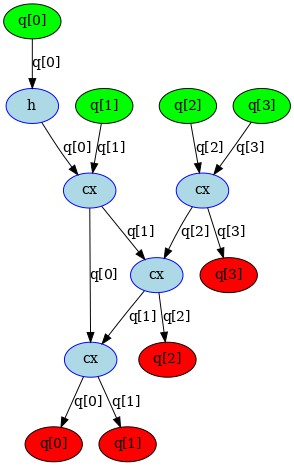

In [67]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.dagcircuit import DAGCircuit
from qiskit.converters import circuit_to_dag
from qiskit.visualization import dag_drawer
 
q = QuantumRegister(4, 'q')
# c = ClassicalRegister(3, 'c')
# circ = QuantumCircuit(q, c)
circ = QuantumCircuit(q)
circ.h(q[0])
circ.cx(q[0], q[1])
circ.cx(q[2], q[3])
circ.cx(q[1], q[2])
circ.cx(q[0], q[1])
# circ.measure(q[0], c[0])
# circ.rz(0.5, q[1]).c_if(c, 2)
 
print(circ)

dag = circuit_to_dag(circ)
dag_drawer(dag)

In [69]:
# from pprint import pprint

dag_qubit_map = {bit: index for index, bit in enumerate(dag.qubits)}

# for node in dag.gate_nodes():
#     # print(type(node))#, ":")
#     # print(node.op)
#     # print(node.qargs[0])
#     # print(node.sort_key)
#     if node.op.num_qubits> 1:
#         print(dag_qubit_map[node.qargs[0]],dag_qubit_map[node.qargs[1]])
#     print("---------")
#     # print()
#     # pprint(vars(node))
#     # print(vars(node))

#     # for n2 in (dag.predecessors(node)):
#     #     print(n2)
# # # print(dag.wires)
# # # dag.bfs_successors(124546370769216)

while len(dag.gate_nodes())>0:
    gate_set = []
    for node in dag.front_layer():
        if node.op.num_qubits< 2:
            dag.remove_op_node(node)
        if node.op.num_qubits>= 2:
            gate_set.append((dag_qubit_map[node.qargs[0]],dag_qubit_map[node.qargs[1]]))
            dag.remove_op_node(node)
    print(gate_set)
    # print("---------")



[(0, 1), (2, 3)]
[(1, 2)]
[(0, 1)]


In [24]:
for i in range(4):
    print(dag.node(i))

124546372796736
124546370881344
124546372761728
124546370772480
